In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import shap
from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score, 
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc)

In [2]:
# Load the dataset
df = pd.read_csv('combined.00-25.csv')

In [3]:
# Fill missing/empty 'totalNonCurrentLiabilities' with 'totalLiabilities'
df['totalCurrentLiabilities'] = df['totalCurrentLiabilities'].fillna(df['totalLiabilities'])

# df.loc[df['totalEquity'] == 0, 'totalEquity'] = (
#     df['totalLiabilitiesAndTotalEquity'] - df['totalLiabilities']
# )

# Creating metrics and ratios.
df['totalEquity'] = df['totalLiabilitiesAndTotalEquity'] - df['totalLiabilities']
df['currentRatio'] = df['totalCurrentAssets'] / df['totalCurrentLiabilities']
df['debtToEquity'] = df['totalDebt'] / df['totalEquity']
df['ROE'] = df['netIncome_x'] / df['totalEquity']
df['inventoryTurnover'] = df['costOfRevenue'] / df['inventory_x']
df['Return'] = df.groupby('symbol_stock')['Adj Close'].pct_change()
df['ROA'] = df['netIncome_x'] / df['totalAssets']
df['free_cash_flow_yield'] = df['freeCashFlow'] / df['totalEquity']

df['Profit_Margin'] = df['netIncome_x'] / df['revenue']
df['Op_Cash_Flow_to_Revenue'] = df['operatingCashFlow'] / df['revenue']

if 'dividendsPaid' in df.columns and 'netIncome_x' in df.columns:
    df['retained_earnings'] = df['netIncome_x'] - df['dividendsPaid']
    # Compute a ratio of what fraction of net income is retained.
    df['re_ratio'] = df['retained_earnings'] / df['netIncome_x']

df['capital_light'] = df['capitalExpenditure'] / df['operatingCashFlow']

# df['re_ratio'] = df[ 'retainedEarnings'] / df['netIncome_x']

# Metrics after looking at Sector-level correlation
df['goodwillIntangible_to_assets'] = df['goodwillAndIntangibleAssets'] / df['totalAssets']
df['sellingMarketing_to_revenue'] = df['sellingAndMarketingExpenses'] / df['revenue']
df['totalInvestments_to_assets'] = df['totalInvestments'] / df['totalAssets']
df['rnd_to_revenue'] = df['researchAndDevelopmentExpenses'] / df['revenue']
df['inventory_to_assets'] = df['inventory_x'] / df['totalAssets']

In [4]:
# 2. Data Cleaning & Date Conversion
# Use 'acceptedDate_x' as the release date of the financial statement.
df['accepted_date'] = pd.to_datetime(df['acceptedDate_x'])


# Define Future Return Horizon - in days - for the target return.
# 365 days for a 1-year return. Change to 3*365 or 5*365
horizon_days = 365 * 5

# Create a new column that marks the target date from where future return will be calculated.
df['target_date'] = df['accepted_date'] + pd.Timedelta(days=horizon_days)

df = df.sort_values(by=['symbol_stock', 'accepted_date'])

# Attach Future Price Using Merge_asof by creating a separate dataframe containing each company's 
# accepted_date and Adj Close, then rename columns so it's possible to merge on time.
df_prices = df[['symbol_stock', 'accepted_date', 'Adj Close']].rename(
    columns={'accepted_date': 'future_date', 'Adj Close': 'future_price'}
)

df = df.sort_values('target_date')

df_prices = df[['symbol_stock', 'accepted_date', 'Adj Close']].rename(
    columns={'accepted_date': 'future_date', 'Adj Close': 'future_price'}
).sort_values('future_date')

print(df['accepted_date'].isnull().sum())
print(df['target_date'].isnull().sum())

df = df.dropna(subset=['accepted_date'])
df['target_date'] = df['accepted_date'] + pd.Timedelta(days=horizon_days)
df_prices = df_prices.dropna(subset=['future_date'])

df_model = pd.merge_asof(
    left=df,
    right=df_prices,
    left_on='target_date',
    right_on='future_date',
    by='symbol_stock',
    direction='forward'
)

# Compute Future Return by calculating the percentage return over the horizon.
df_model['Return_future'] = (df_model['future_price'] - df_model['Adj Close']) / df_model['Adj Close']

# Remove rows where the future price and future return is not available.
df_model = df_model.dropna(subset=['Return_future']).copy()

# Define the Target Variable by creating a binary target: 
# label as 1 if the future return is positive (good stock), and 0 otherwise.
# df_model['good_stock'] = (df_model['Return_future'] > 0.0825).astype(int)
df_model['good_stock'] = (df_model['Return_future'] > 0.25).astype(int)

17
17


In [5]:
# Dropping nan because don't feel comfortable with imputing with mean or median
# Good chance company might not have debt or assets, etc. 
# Results in only dropping a few thousand rows out of ~155k rows.
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model = df_model.dropna(subset=['ROE', 'ROA', 'free_cash_flow_yield', 'debtToEquity', 'eps',  'epsdiluted',
                                    're_ratio', 'Op_Cash_Flow_to_Revenue', 'ebitda', 'ebitdaratio',
                                    
                                    'goodwillIntangible_to_assets', 'sellingMarketing_to_revenue', 
                                    'totalInvestments_to_assets', 'rnd_to_revenue', 'inventory_to_assets',
                                    'Profit_Margin'])

df_model.shape

(154722, 159)

Performing winsorization on most, if not all, of the features. I went through the dataset and looked at the extreme values. Most are legitimate, but are wild outliers so they are capped. The high or low values are maintained but the magnitude is lessened. Since most of the features are ratios, -80,000% isn't reasonable.

The winsorized columns are better correlated with returns/good_stock as well.

In [6]:
#goodwillIntangible_to_assets
print(df_model['Profit_Margin'].mean())
df_model['Profit_Margin_win'] = winsorize(df_model['Profit_Margin'], limits=[0.01, 0.01])
print(df_model['Profit_Margin_win'].mean())

print("Profit_Margin range:", df_model['Profit_Margin'].min(), df_model['Profit_Margin'].max())
print("Profit_Margin winsorized range:", df_model['Profit_Margin_win'].min(), df_model['Profit_Margin_win'].max())


#goodwillIntangible_to_assets
print(df_model['inventory_to_assets'].mean())
df_model['inventory_to_assets_win'] = winsorize(df_model['inventory_to_assets'], limits=[0.01, 0.01])
print(df_model['inventory_to_assets_win'].mean())

print("inventory_to_assets range:", df_model['inventory_to_assets'].min(), df_model['inventory_to_assets'].max())
print("inventory_to_assets winsorized range:", df_model['inventory_to_assets_win'].min(), df_model['inventory_to_assets_win'].max())


#goodwillIntangible_to_assets
print(df_model['rnd_to_revenue'].mean())
df_model['rnd_to_revenue_win'] = winsorize(df_model['rnd_to_revenue'], limits=[0.01, 0.01])
print(df_model['rnd_to_revenue_win'].mean())

print("rnd_to_revenue range:", df_model['rnd_to_revenue'].min(), df_model['rnd_to_revenue'].max())
print("rnd_to_revenue winsorized range:", df_model['rnd_to_revenue_win'].min(), df_model['rnd_to_revenue_win'].max())


#goodwillIntangible_to_assets
print(df_model['totalInvestments_to_assets'].mean())
df_model['totalInvestments_to_assets_win'] = winsorize(df_model['totalInvestments_to_assets'], limits=[0.01, 0.01])
print(df_model['totalInvestments_to_assets_win'].mean())

print("totalInvestments_to_assets range:", df_model['totalInvestments_to_assets'].min(), df_model['totalInvestments_to_assets'].max())
print("totalInvestments_to_assets winsorized range:", df_model['totalInvestments_to_assets_win'].min(), df_model['totalInvestments_to_assets_win'].max())


#goodwillIntangible_to_assets
print(df_model['goodwillIntangible_to_assets'].mean())
df_model['goodwillIntangible_to_assets_win'] = winsorize(df_model['goodwillIntangible_to_assets'], limits=[0.01, 0.01])
print(df_model['goodwillIntangible_to_assets_win'].mean())

print("goodwillIntangible_to_assets range:", df_model['goodwillIntangible_to_assets'].min(), df_model['goodwillIntangible_to_assets'].max())
print("goodwillIntangible_to_assets winsorized range:", df_model['goodwillIntangible_to_assets_win'].min(), df_model['goodwillIntangible_to_assets_win'].max())


# sellingMarketing_to_revenue
print(df_model['sellingMarketing_to_revenue'].mean())
df_model['sellingMarketing_to_revenue_win'] = winsorize(df_model['sellingMarketing_to_revenue'], limits=[0.01, 0.01])
print(df_model['sellingMarketing_to_revenue_win'].mean())

print("sellingMarketing_to_revenue range:", df_model['sellingMarketing_to_revenue'].min(), df_model['sellingMarketing_to_revenue'].max())
print("sellingMarketing_to_revenue winsorized range:", df_model['sellingMarketing_to_revenue_win'].min(), df_model['sellingMarketing_to_revenue_win'].max())


# ebitda
print(df_model['ebitda'].mean())
df_model['ebitda_win'] = winsorize(df_model['ebitda'], limits=[0.01, 0.01])
print(df_model['ebitda_win'].mean())

print("ebitda range:", df_model['ebitda'].min(), df_model['ebitda'].max())
print("ebitda winsorized range:", df_model['ebitda_win'].min(), df_model['ebitda_win'].max())


# ebitdaratio
print(df_model['ebitdaratio'].mean())
df_model['ebitdaratio_win'] = winsorize(df_model['ebitdaratio'], limits=[0.01, 0.01])
print(df_model['ebitdaratio_win'].mean())

print("ebitdaratio range:", df_model['ebitdaratio'].min(), df_model['ebitdaratio'].max())
print("ebitdaratio winsorized range:", df_model['ebitdaratio_win'].min(), df_model['ebitdaratio_win'].max())


# ROE
print(df_model['ROE'].mean())
df_model['roe_win'] = winsorize(df_model['ROE'], limits=[0.01, 0.01])
print(df_model['roe_win'].mean())

print("ROE range:", df_model['ROE'].min(), df_model['ROE'].max())
print("ROE winsorized range:", df_model['roe_win'].min(), df_model['roe_win'].max())


# ROA
print(df_model['ROA'].mean())
df_model['roa_win'] = winsorize(df_model['ROA'], limits=[0.01, 0.01])
print(df_model['roa_win'].mean())

print("ROA range:", df_model['ROA'].min(), df_model['ROA'].max())
print("ROA winsorized range:", df_model['roa_win'].min(), df_model['roa_win'].max())


# free_cash_flow_yield
print(df_model['free_cash_flow_yield'].mean())
df_model['fcf_win'] = winsorize(df_model['free_cash_flow_yield'], limits=[0.01, 0.01])
print(df_model['fcf_win'].mean())

print("free_cash_flow_yield range:", df_model['free_cash_flow_yield'].min(), df_model['free_cash_flow_yield'].max())
print("free_cash_flow_yield winsorized range:", df_model['fcf_win'].min(), df_model['fcf_win'].max())


# debtToEquity
print(df_model['debtToEquity'].mean())
df_model['debt_win'] = winsorize(df_model['debtToEquity'], limits=[0.01, 0.01])
print(df_model['debt_win'].mean())

print("debtToEquity range:", df_model['debtToEquity'].min(), df_model['debtToEquity'].max())
print("debtToEquity winsorized range:", df_model['debt_win'].min(), df_model['debt_win'].max())


# re_ratio
print(df_model['re_ratio'].mean())
df_model['re_win'] = winsorize(df_model['re_ratio'], limits=[0.05, 0.05])
print(df_model['re_win'].mean())

print("re_ratio range:", df_model['re_ratio'].min(), df_model['re_ratio'].max())
print("re_ratio winsorized range:", df_model['re_win'].min(), df_model['re_win'].max())


# eps
print(df_model['eps'].mean())
df_model['eps_win'] = winsorize(df_model['eps'], limits=[0.05, 0.05])
print(df_model['eps_win'].mean())

print("eps range:", df_model['eps'].min(), df_model['eps'].max())
print("eps winsorized range:", df_model['eps_win'].min(), df_model['eps_win'].max())


# epsdiluted
print(df_model['epsdiluted'].mean())
df_model['epsdiluted_win'] = winsorize(df_model['epsdiluted'], limits=[0.05, 0.05])
print(df_model['epsdiluted_win'].mean())

print("epsdiluted range:", df_model['epsdiluted'].min(), df_model['epsdiluted'].max())
print("epsdiluted winsorized range:", df_model['epsdiluted_win'].min(), df_model['epsdiluted_win'].max())


# Op_Cash_Flow_to_Revenue
print(df_model['Op_Cash_Flow_to_Revenue'].mean())
df_model['Op_Cash_Flow_to_Revenue_win'] = winsorize(df_model['Op_Cash_Flow_to_Revenue'], limits=[0.05, 0.05])
print(df_model['Op_Cash_Flow_to_Revenue_win'].mean())

print("Op_Cash_Flow_to_Revenue range:", df_model['Op_Cash_Flow_to_Revenue'].min(), df_model['Op_Cash_Flow_to_Revenue'].max())
print("Op_Cash_Flow_to_Revenue winsorized range:", df_model['Op_Cash_Flow_to_Revenue_win'].min(), df_model['Op_Cash_Flow_to_Revenue_win'].max())

-86.50234890121564
-0.1128143553262321
Profit_Margin range: -12.815603376530733 1.4815177437804399
Profit_Margin winsorized range: -12.815603376530733 1.4815177437804399
2.7218624371924203
0.0792689143424646
inventory_to_assets range: -0.032017201489100124 0.5672233318344854
inventory_to_assets winsorized range: -0.032017201489100124 0.5672233318344854
57.004844555123185
0.09314365867723011
rnd_to_revenue range: -0.0 4.295006570302234
rnd_to_revenue winsorized range: -0.0 4.295006570302234
174.81180350628864
0.14327274064377085
totalInvestments_to_assets range: -0.10085953650310087 0.9954933312932704
totalInvestments_to_assets winsorized range: -0.10085953650310087 0.9954933312932704
1.1568147126123858
0.14629779466620588
goodwillIntangible_to_assets range: -0.017708296635546943 0.7478991596638656
goodwillIntangible_to_assets winsorized range: -0.017708296635546943 0.7478991596638656
-62.76064030955583
0.036571310033851404
sellingMarketing_to_revenue range: -0.02299358832633208 0.60276

In [7]:
# Stating features; using the winsorized versions of most features and focusing on mostly
# ratios to capture context and not let raw $$ metrics overwhelm
features = ['roe_win', 'roa_win', 'fcf_win', 'debt_win', 're_win', 'eps_win', 'epsdiluted_win',
            'ebitda', 'ebitdaratio', 
            'goodwillIntangible_to_assets_win', 'sellingMarketing_to_revenue_win', 'totalInvestments_to_assets_win',
            'rnd_to_revenue_win', 'inventory_to_assets_win', 'Profit_Margin_win']

In [8]:
# Correlation matrix with 'good_stock'
corr_matrix = df_model[features + ['good_stock']].corr()
corr_matrix

,roe_win,roa_win,fcf_win,debt_win,re_win,eps_win,epsdiluted_win,ebitda,ebitdaratio,goodwillIntangible_to_assets_win,sellingMarketing_to_revenue_win,totalInvestments_to_assets_win,rnd_to_revenue_win,inventory_to_assets_win,Profit_Margin_win,good_stock
roe_win,1.000000,0.522343,0.423470,0.060939,0.071628,0.365959,0.366607,0.072940,0.225492,0.028371,-0.067434,-0.040270,-0.227254,0.030313,0.273958,0.029255
roa_win,0.522343,1.000000,0.208657,-0.011576,0.102562,0.502662,0.504035,0.095593,0.498640,0.054774,-0.096657,-0.058425,-0.494581,0.071435,0.596125,0.071668
fcf_win,0.423470,0.208657,1.000000,0.084368,0.018628,0.124287,0.124941,0.036640,0.127057,0.073758,-0.011223,-0.025658,-0.141960,0.005097,0.135280,0.041809
debt_win,0.060939,-0.011576,0.084368,1.000000,0.063098,0.030012,0.029148,0.017337,0.089146,0.008242,-0.057507,-0.020137,-0.067471,-0.069178,0.049202,-0.005721
re_win,0.071628,0.102562,0.018628,0.063098,1.000000,0.112673,0.116033,0.047156,0.148238,-0.089075,-0.096478,0.066252,-0.108221,-0.136938,0.124903,0.021870
eps_win,0.365959,0.502662,0.124287,0.030012,0.112673,1.000000,0.998998,0.285965,0.260125,0.021253,-0.078625,0.036068,-0.220907,-0.019829,0.296129,-0.013064
epsdiluted_win,0.366607,0.504035,0.124941,0.029148,0.116033,0.998998,1.000000,0.286431,0.262157,0.020687,-0.079211,0.036309,-0.222604,-0.019940,0.297822,-0.011938
ebitda,0.072940,0.095593,0.036640,0.017337,0.047156,0.285965,0.286431,1.000000,0.048985,0.013575,0.000245,-0.008774,-0.037915,-0.054828,0.046692,-0.022629
ebitdaratio,0.225492,0.498640,0.127057,0.089146,0.148238,0.260125,0.262157,0.048985,1.000000,0.008191,-0.059647,-0.030446,-0.752202,-0.005458,0.895018,0.062425
goodwillIntangible_to_assets_win,0.028371,0.054774,0.073758,0.008242,-0.089075,0.021253,0.020687,0.013575,0.008191,1.000000,0.103095,-0.308902,-0.037393,0.007798,0.026489,0.035769


In [9]:
# Correlation matrix with 'Return_future'
corr_matrix = df_model[features + ['Return_future']].corr()
corr_matrix

,roe_win,roa_win,fcf_win,debt_win,re_win,eps_win,epsdiluted_win,ebitda,ebitdaratio,goodwillIntangible_to_assets_win,sellingMarketing_to_revenue_win,totalInvestments_to_assets_win,rnd_to_revenue_win,inventory_to_assets_win,Profit_Margin_win,Return_future
roe_win,1.000000,0.522343,0.423470,0.060939,0.071628,0.365959,0.366607,0.072940,0.225492,0.028371,-0.067434,-0.040270,-0.227254,0.030313,0.273958,-0.023983
roa_win,0.522343,1.000000,0.208657,-0.011576,0.102562,0.502662,0.504035,0.095593,0.498640,0.054774,-0.096657,-0.058425,-0.494581,0.071435,0.596125,-0.042541
fcf_win,0.423470,0.208657,1.000000,0.084368,0.018628,0.124287,0.124941,0.036640,0.127057,0.073758,-0.011223,-0.025658,-0.141960,0.005097,0.135280,0.002744
debt_win,0.060939,-0.011576,0.084368,1.000000,0.063098,0.030012,0.029148,0.017337,0.089146,0.008242,-0.057507,-0.020137,-0.067471,-0.069178,0.049202,-0.006850
re_win,0.071628,0.102562,0.018628,0.063098,1.000000,0.112673,0.116033,0.047156,0.148238,-0.089075,-0.096478,0.066252,-0.108221,-0.136938,0.124903,-0.049327
eps_win,0.365959,0.502662,0.124287,0.030012,0.112673,1.000000,0.998998,0.285965,0.260125,0.021253,-0.078625,0.036068,-0.220907,-0.019829,0.296129,-0.065870
epsdiluted_win,0.366607,0.504035,0.124941,0.029148,0.116033,0.998998,1.000000,0.286431,0.262157,0.020687,-0.079211,0.036309,-0.222604,-0.019940,0.297822,-0.065724
ebitda,0.072940,0.095593,0.036640,0.017337,0.047156,0.285965,0.286431,1.000000,0.048985,0.013575,0.000245,-0.008774,-0.037915,-0.054828,0.046692,-0.027183
ebitdaratio,0.225492,0.498640,0.127057,0.089146,0.148238,0.260125,0.262157,0.048985,1.000000,0.008191,-0.059647,-0.030446,-0.752202,-0.005458,0.895018,-0.006383
goodwillIntangible_to_assets_win,0.028371,0.054774,0.073758,0.008242,-0.089075,0.021253,0.020687,0.013575,0.008191,1.000000,0.103095,-0.308902,-0.037393,0.007798,0.026489,0.001484


In [10]:
target = 'good_stock'

# Compute the Spearman correlation matrix since target in this case is binary
spearman_corr_matrix = df_model[features + [target]].corr(method='spearman')

# Spearman correlation values for 'good_stock'
spearman_corr_target = spearman_corr_matrix[target].drop(target)

spearman_top_features = spearman_corr_target.abs().sort_values(ascending=False)
print("Spearman Rank Correlation for good_stock:")
print(spearman_top_features)

Spearman Rank Correlation for good_stock:
fcf_win                             0.071406
roa_win                             0.064082
ebitda                              0.050691
roe_win                             0.042137
re_win                              0.037094
totalInvestments_to_assets_win      0.034805
goodwillIntangible_to_assets_win    0.031080
inventory_to_assets_win             0.029817
debt_win                            0.019838
rnd_to_revenue_win                  0.019516
Profit_Margin_win                   0.014351
ebitdaratio                         0.013317
eps_win                             0.011635
epsdiluted_win                      0.011166
sellingMarketing_to_revenue_win     0.010436
Name: good_stock, dtype: float64


Correlation numbers are still low. This is common in financial analysis because features have non-linear relationships with the target. Also, it takes more than just one or a handful of features to determine a company's health. In this case, the flow of cash, return on assets, equity and earnings seem to be relatively important. This seems very reasonable.

Let's try to do this per Sector.

In [11]:
df_model['good_stock'].value_counts()

good_stock
1    96038
0    58684
Name: count, dtype: int64

In [ ]:
# List the columns to ignore (mostly date or extra columns)
ignore_cols = [
    'good_stock', 'calendarYear', 'calendarYear_y', 'calendarYear_x', 
    'Adj Close', 'quarter_number', 'future_price', 
    'cik_x', 'cik_y', 'cik', 'Unnamed: 0.1', 'Unnamed: 0',
    'Return_future'
]

# Get unique sectors
sectors = df_model['Sector'].unique()

# Dictionary to store Spearman correlations for each sector
sector_spearman = {}

# Set how many top features per sector to consider as votes
# Using a 'first-past-the-post' type voting system where a sector contributes more than one vote
# In this case, each sector has 20 votes
top_n_per_sector = 20

for sector in sectors:
    print(f"Processing sector: {sector}")
    
    # Filter the DataFrame
    df_sector = df_model[df_model['Sector'] == sector].copy()
    
    df_sector_numeric = df_sector.select_dtypes(include=['number'])
    df_sector_numeric = df_sector_numeric.drop(columns=ignore_cols, errors='ignore')
    
    # Add the 'good_stock' column back into the numeric DataFrame
    df_sector_numeric['good_stock'] = df_sector['good_stock']
    
    # Spearman correlation for all numeric features with 'good_stock'
    spearman_corr = df_sector_numeric.corr(method='spearman')['good_stock'].drop('good_stock')
    
    # Sort features by the absolute Spearman correlation (descending) and take the top N features
    top_spearman = spearman_corr.abs().sort_values(ascending=False).head(top_n_per_sector)
    sector_spearman[sector] = top_spearman
    
    print("Top Spearman correlations:")
    print(top_spearman)
    print("-" * 50)
    print("-" * 50)

# Aggregate the top 'votes' or, features, across sectors
all_votes = []
for sector, top_feats in sector_spearman.items():
    all_votes.extend(top_feats.index.tolist())

# Count how many times each feature appears in the top lists
vote_counts = Counter(all_votes)
vote_counts_df = pd.DataFrame.from_dict(vote_counts, orient='index', columns=['Votes'])
vote_counts_df = vote_counts_df.sort_values(by='Votes', ascending=False)

print("Aggregated Spearman vote counts:")
print(vote_counts_df)

Processing sector: Consumer Defensive
Top Spearman correlations:
weightedAverageShsOut            0.134908
weightedAverageShsOutDil         0.134342
freeCashFlow                     0.105589
capitalLeaseObligations          0.100756
inventory_x                      0.096612
shortTermDebt                    0.091875
depreciationAndAmortization_x    0.091462
roe_win                          0.090532
ROE                              0.090532
fcf_win                          0.090469
free_cash_flow_yield             0.090469
retained_earnings                0.086722
netIncome_y                      0.086460
netIncome_x                      0.085182
revenue                          0.084613
ebitda_win                       0.080826
ebitda                           0.080826
operatingIncome                  0.079983
incomeBeforeTax                  0.079840
totalCurrentLiabilities          0.079080
Name: good_stock, dtype: float64
--------------------------------------------------
-----------

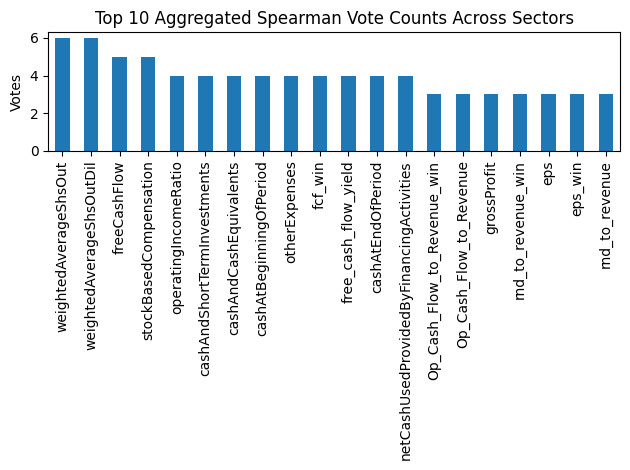

In [ ]:
# Take the first 20 rows
top_20_vote_counts = vote_counts_df.head(20)

top_20_vote_counts.plot(kind='bar', title='Top 20 Aggregated Spearman Vote Counts', legend=False)
plt.ylabel('Votes')
plt.tight_layout()
plt.show()

In [19]:
# Shapiro-Wilk Normality Test - to check for feature normality
# 
for feature in features:
    # Drop NaNs for the test
    data = df_model[feature].dropna()
    stat, p = shapiro(data)
    print(f"{feature}: p-value = {p:.4f}")
    if p < 0.05:
        print(f"  - {feature} likely deviates from normality.\n")
    else:
        print(f"  - {feature} likely is normally distributed.\n")

roe_win: p-value = 0.0000
  - roe_win likely deviates from normality.

roa_win: p-value = 0.0000
  - roa_win likely deviates from normality.

fcf_win: p-value = 0.0000
  - fcf_win likely deviates from normality.

debt_win: p-value = 0.0000
  - debt_win likely deviates from normality.

re_win: p-value = 0.0000
  - re_win likely deviates from normality.

eps_win: p-value = 0.0000
  - eps_win likely deviates from normality.

epsdiluted_win: p-value = 0.0000
  - epsdiluted_win likely deviates from normality.

ebitda: p-value = 0.0000
  - ebitda likely deviates from normality.

ebitdaratio: p-value = 0.0000
  - ebitdaratio likely deviates from normality.

goodwillIntangible_to_assets_win: p-value = 0.0000
  - goodwillIntangible_to_assets_win likely deviates from normality.

sellingMarketing_to_revenue_win: p-value = 0.0000
  - sellingMarketing_to_revenue_win likely deviates from normality.

totalInvestments_to_assets_win: p-value = 0.0000
  - totalInvestments_to_assets_win likely deviates f

Since the features are not normally distributed, we will run a Mann-Whitney U test for features differences by good_stock, as opposed to a t-test which assumes normality.

In [20]:
for feature in features:
    group_good = df_model[df_model['good_stock'] == 1][feature].dropna()
    group_bad = df_model[df_model['good_stock'] == 0][feature].dropna()
    stat, p = mannwhitneyu(group_good, group_bad, alternative='two-sided')
    print(f"{feature}: U-statistic = {stat:.2f}, p-value = {p:.4f}")

# Perform the test by sector to explore sector-specific differences:
if 'Sector' in df_model.columns:
    print("\nMann-Whitney U Test by Sector:")
    for sector in df_model['Sector'].unique():
        print(f"\nSector: {sector}")
        df_sector = df_model[df_model['Sector'] == sector]
        for feature in features:
            group_good = df_sector[df_sector['good_stock'] == 1][feature].dropna()
            group_bad = df_sector[df_sector['good_stock'] == 0][feature].dropna()
            
            if len(group_good) > 0 and len(group_bad) > 0:
                stat, p = mannwhitneyu(group_good, group_bad, alternative='two-sided')
                print(f"  {feature}: U-statistic = {stat:.2f}, p-value = {p:.4f}")
            else:
                print(f"  {feature}: Insufficient data in one or both groups.")

roe_win: U-statistic = 2959235271.50, p-value = 0.0000
roa_win: U-statistic = 3032818185.50, p-value = 0.0000
fcf_win: U-statistic = 3057375151.50, p-value = 0.0000
debt_win: U-statistic = 2884419297.50, p-value = 0.0000
re_win: U-statistic = 2937979903.50, p-value = 0.0000
eps_win: U-statistic = 2778939793.50, p-value = 0.0000
epsdiluted_win: U-statistic = 2780512831.50, p-value = 0.0000
ebitda: U-statistic = 2987737413.50, p-value = 0.0000
ebitdaratio: U-statistic = 2862600004.50, p-value = 0.0000
goodwillIntangible_to_assets_win: U-statistic = 2921710655.50, p-value = 0.0000
sellingMarketing_to_revenue_win: U-statistic = 2789324652.00, p-value = 0.0000
totalInvestments_to_assets_win: U-statistic = 2702253898.00, p-value = 0.0000
rnd_to_revenue_win: U-statistic = 2767100161.00, p-value = 0.0000
inventory_to_assets_win: U-statistic = 2916743633.00, p-value = 0.0000
Profit_Margin_win: U-statistic = 2866066893.50, p-value = 0.0000

Mann-Whitney U Test by Sector:

Sector: Consumer Defens